In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

Pclass -0.6305479068752845
Age 0.38910778230082704
SibSp 3.6953517271630565
Parch 2.7491170471010933
Fare 4.787316519674893


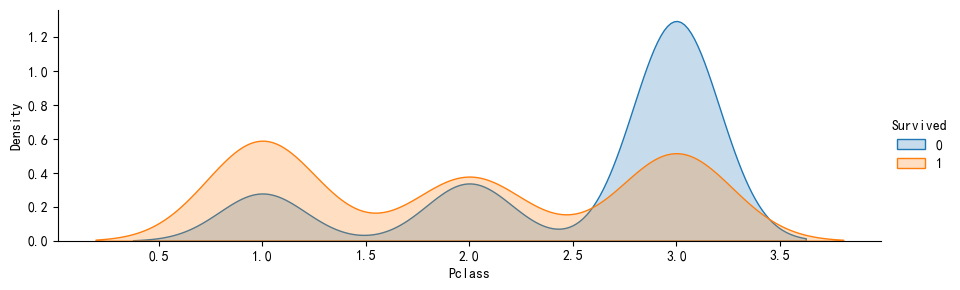

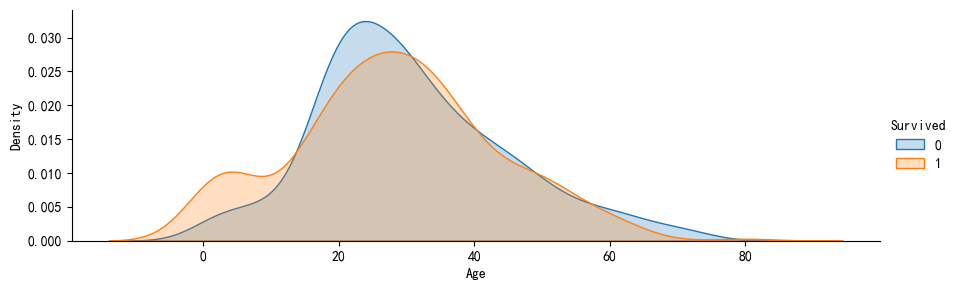

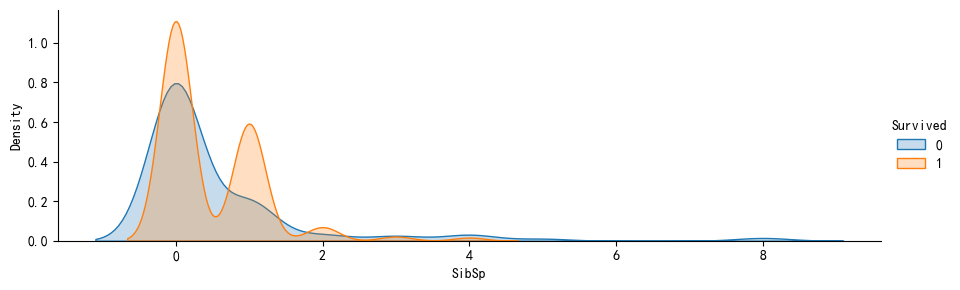

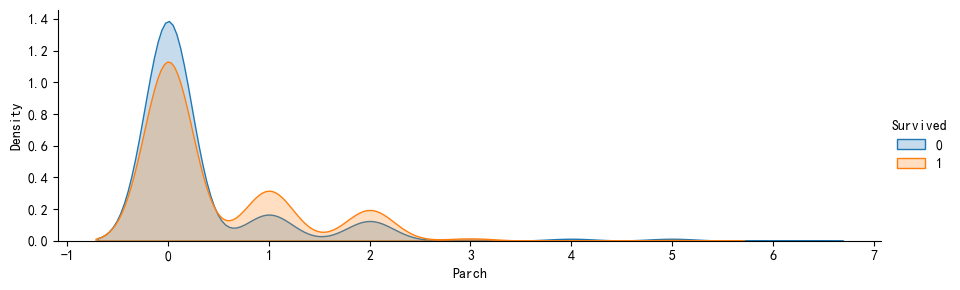

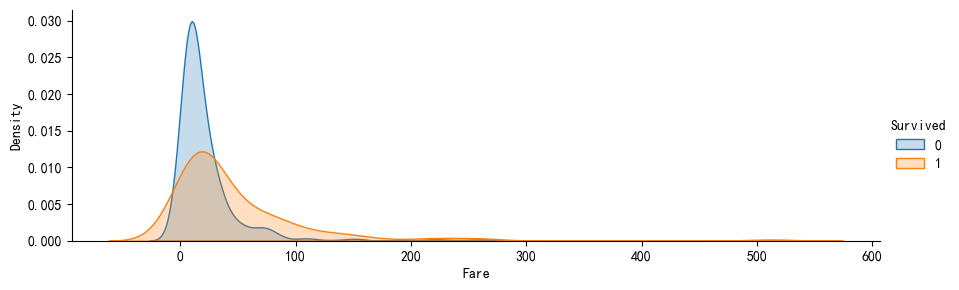

In [182]:
import seaborn as sns
for i in train.columns:
    if train[i].dtype!='object' and i not in ('PassengerId','Survived'):
        ageFacet=sns.FacetGrid(train,hue='Survived',aspect=3)
        #作图，选择图形类型
        ageFacet.map(sns.kdeplot,i,shade=True)
        #其他信息：坐标轴范围、标签等
        ageFacet.add_legend()
        print(i,train[i].skew())

In [183]:
df=pd.concat([train,test])
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [4]:
df = pd.concat([train,test])
df.drop(['PassengerId'],axis=1,inplace=True)
df['Title'] = df['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
TitleDict = {'Mr':'Mr', 'Mlle':'Miss', 'Miss':'Miss', 'Master':'Master', 'Jonkheer':'Royalty', 'Mme':'Mrs', 'Ms':'Mrs', 
             'Mrs':'Mrs', 'Don':'Royalty', 'Sir':'Royalty', 'the Countess':'Royalty', 'Dona':'Royalty', 'Lady':'Royalty', 
             'Capt':'Officer', 'Col':'Officer', 'Major':'Officer', 'Dr':'Officer', 'Rev':'Officer'}
df['Sex'] = df['Sex'].map({'male':1,'female':0})
df['Title'] = df['Title'].map(TitleDict)
df.drop('Name', axis=1, inplace=True)
df['familyNum'] = (df['Parch']+df['SibSp']+1)
df['Cabin'] = df['Cabin'].str[0].fillna('N')
df['Embarked'] = df['Embarked'].fillna('S')
df['Fare'] = df['Fare'].fillna(7.225)
df['Fare'] = np.log1p(df['Fare'])
df['SibSp'] = np.log1p(df['SibSp'])
df['SibSp'] = np.log1p(df['Parch'])
df['Pclass'] = df['Pclass'].astype(str)

import re
def extract_ticket_prefix(ticket):
    ticket = str(ticket)
    if '/' in ticket:
        ticket = ticket.split('/')[0]
    prefix = re.sub('[^a-zA-Z]', '', ticket)
    return prefix if prefix else 'NONE'

def extract_ticket_number(ticket):
    if type(ticket)==int:
        return ticket//1000
    if ' ' in ticket:
        ticket = ticket.split(' ')[-1]
    numbers = re.sub('[^0-9]', '', ticket)
    return int(numbers)//1000 if numbers else 0

df['Ticket_Prefix'] = df['Ticket'].apply(extract_ticket_prefix)
df['Ticket_Number'] = np.log1p(df['Ticket'].apply(extract_ticket_number))
df['Ticket_Number'].replace(3101,400)
df['Group_Size'] = df.groupby('Ticket')['Ticket'].transform('count')
prefix_counts = df['Ticket_Prefix'].value_counts()
rare_prefixes = prefix_counts[prefix_counts < 5].index
df['Ticket_Prefix'] = df['Ticket_Prefix'].replace(rare_prefixes, 'RARE')
df.drop('Ticket',axis=1,inplace=True)


colunm=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'Embarked', 'Title', 'familyNum', 'Ticket_Prefix', 'Ticket_Number',
       'Group_Size']
Agepre=df[colunm]
Agepre=pd.get_dummies(Agepre)
AgeKnown=Agepre[Agepre['Age'].notnull()]
AgeUnKnown=Agepre[Agepre['Age'].isnull()]

AgeKnown_X=AgeKnown.drop(['Age'],axis=1)
AgeKnown_y=AgeKnown['Age']
AgeUnKnown_X=AgeUnKnown.drop(['Age'],axis=1)

#利用随机森林构建模型
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(n_jobs=-1)
rfr.fit(AgeKnown_X,AgeKnown_y)
print(rfr.score(AgeKnown_X,AgeKnown_y))

AgeUnKnown_y=rfr.predict(AgeUnKnown_X)
df.loc[df['Age'].isnull(),['Age']]=AgeUnKnown_y
df=pd.get_dummies(df)

0.8425226063493491


In [5]:
n=train.shape[0]
x=df.drop('Survived',axis=1)
columns=x.columns
y=df['Survived']
# from sklearn.preprocessing import StandardScaler
# x=StandardScaler().fit_transform(x)
# from sklearn.decomposition import PCA
# x=PCA().fit_transform(x)
tx,ty=x[:n],y[:n]
pre=x[n:]
tx.shape

(891, 42)

In [6]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
lg=LogisticRegression()
cross_val_score(lg, tx, ty, scoring='accuracy', cv=sk).mean()

0.8237775406440273

In [228]:
lg.fit(tx,ty)
predictions = lg.predict(pre)
ans_df=pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':map(int,predictions)})
ans_df.to_csv('LG_submission.csv',index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = [
    # 线性模型
    LogisticRegression(),
    LogisticRegressionCV(),
    RidgeClassifier(),
    SGDClassifier(loss='log_loss'),
    
    # 树模型
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    ExtraTreesClassifier(),
    HistGradientBoostingClassifier(),
    
    # 支持向量机
    SVC(),
    NuSVC(),
    
    # 贝叶斯模型
    GaussianNB(var_smoothing=1e-9),
    BernoulliNB(alpha=1.0),
    
    # 距离模型
    KNeighborsClassifier(n_neighbors=15, weights='distance'),
    
    MLPClassifier(),
    # XGBoost模型
    XGBClassifier(),
    XGBRFClassifier(),

    LGBMClassifier(verbose=-1),

    CatBoostClassifier(verbose=False)
]

for m in models:
    print(m.__class__.__name__)
    sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
    print(cross_val_score(m, tx, ty, scoring='accuracy', cv=sk).mean())

LogisticRegression
0.8237775406440273
LogisticRegressionCV
0.8215366267026551
RidgeClassifier
0.8204130311970372
SGDClassifier
0.713652626953738
DecisionTreeClassifier
0.7879040863724813
ExtraTreeClassifier
0.7889460799698701
RandomForestClassifier
0.8360931517167787
GradientBoostingClassifier
0.8361182599962337
ExtraTreesClassifier
0.820387922917582
HistGradientBoostingClassifier
0.8462243424769318
SVC
0.711524700269914
NuSVC
0.8237900947837551
GaussianNB
0.6475299730085996
BernoulliNB
0.7946079969870063
KNeighborsClassifier
0.7553135396396962
XGBClassifier
0.8349758332810244
XGBRFClassifier
0.8372418555018518
LGBMClassifier
0.840606364948842
CatBoostClassifier
0.8417425145941875


In [234]:
import optuna

def rf_search(trial):
    n_estimators = trial.suggest_int("n_estimators", 200, 1000, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 25, step=2)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 50, step=2)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50, step=2)
    sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                min_samples_split=min_samples_split,
                                min_samples_leaf = min_samples_leaf,
                                max_depth=max_depth,
                                n_jobs = -1)
    val = cross_val_score(rf, tx, ty, scoring='accuracy', cv=sk).mean()
    return -val

rf_study = optuna.create_study(study_name='rf')
rf_study.optimize(rf_search, timeout=int(60 * 60), n_trials=300)
rf_params = rf_study.best_params

[I 2025-09-15 15:19:17,985] A new study created in memory with name: rf
[I 2025-09-15 15:19:22,910] Trial 0 finished with value: -0.8193082669010107 and parameters: {'n_estimators': 900, 'max_depth': 15, 'min_samples_split': 46, 'min_samples_leaf': 23}. Best is trial 0 with value: -0.8193082669010107.
[I 2025-09-15 15:19:25,234] Trial 1 finished with value: -0.7889962965287804 and parameters: {'n_estimators': 400, 'max_depth': 13, 'min_samples_split': 38, 'min_samples_leaf': 49}. Best is trial 0 with value: -0.8193082669010107.
[I 2025-09-15 15:19:29,697] Trial 2 finished with value: -0.8249262444291006 and parameters: {'n_estimators': 800, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 15}. Best is trial 2 with value: -0.8249262444291006.
[I 2025-09-15 15:19:31,465] Trial 3 finished with value: -0.7912434875400163 and parameters: {'n_estimators': 300, 'max_depth': 25, 'min_samples_split': 46, 'min_samples_leaf': 47}. Best is trial 2 with value: -0.8249262444291006.
[I 202

In [235]:
import optuna

def lgbm_search(trial):
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "goss"])
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 25, step=2)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    min_child_samples = trial.suggest_int("min_child_samples", 3, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    min_child_weight = trial.suggest_float("min_child_weight", 1e-4, 0.01, log=True)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-6, 0.1, log=True),
    reg_lambda = trial.suggest_float("reg_lambda", 1e-6, 0.1, log=True),
    sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
    lgbm = LGBMClassifier(boosting_type=boosting_type,
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        min_child_samples=min_child_samples,
                        min_child_weight=min_child_weight,
                        min_split_gain=min_split_gain,
                        reg_alpha=reg_alpha,
                        reg_lambda=reg_lambda,
                        n_jobs = -1,
                        verbose = -1)
    val = cross_val_score(lgbm, tx, ty, scoring='accuracy', cv=sk).mean()
    return -val

lgbm_study = optuna.create_study(study_name='lgbm', direction="minimize")
lgbm_study.optimize(lgbm_search, timeout=int(60 * 60), n_trials=300)
lgbm_params = lgbm_study.best_params

[I 2025-09-15 15:30:13,319] A new study created in memory with name: lgbm
[I 2025-09-15 15:30:13,800] Trial 0 finished with value: -0.8417299604544599 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 650, 'max_depth': 15, 'learning_rate': 0.027844144109816366, 'min_child_samples': 10, 'min_split_gain': 0.19122060154779985, 'min_child_weight': 0.00011293671745517095, 'reg_alpha': 0.0001366976351603665, 'reg_lambda': 0.00015990076574379003}. Best is trial 0 with value: -0.8417299604544599.
[I 2025-09-15 15:30:14,024] Trial 1 finished with value: -0.7946079969870065 and parameters: {'boosting_type': 'goss', 'n_estimators': 400, 'max_depth': 11, 'learning_rate': 0.04830679777295683, 'min_child_samples': 89, 'min_split_gain': 0.000957381639460908, 'min_child_weight': 0.006914174906277616, 'reg_alpha': 0.001665308715090176, 'reg_lambda': 0.0012028886637837465}. Best is trial 0 with value: -0.8417299604544599.
[I 2025-09-15 15:30:14,224] Trial 2 finished with value: -0.83387106898499

In [236]:
import optuna

def xgb_search(trial):
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1)
    gamma = trial.suggest_float('gamma', 1, 10, step=0.5)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    max_depth = trial.suggest_int('max_depth', 5, 30, step=1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 15, step=1)
    n_estimators = trial.suggest_int('n_estimators', 200, 1000, step=100)
    sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
    xgb = XGBClassifier(objective = 'binary:logistic',
                        tree_method='hist',
                        colsample_bytree = colsample_bytree, 
                        gamma = gamma, 
                        learning_rate = learning_rate, 
                        max_depth = max_depth, 
                        min_child_weight = min_child_weight, 
                        n_estimators = n_estimators)
    val = cross_val_score(xgb, tx, ty, scoring='accuracy', cv=sk).mean()
    return -val

xgb_study = optuna.create_study(study_name='xgb', direction="minimize")
xgb_study.optimize(xgb_search, timeout=int(60 * 60), n_trials=300)
xgb_params = xgb_study.best_params

[I 2025-09-15 15:32:43,238] A new study created in memory with name: xgb
[I 2025-09-15 15:32:43,581] Trial 0 finished with value: -0.819295712761283 and parameters: {'colsample_bytree': 0.9, 'gamma': 10.0, 'learning_rate': 0.009297173193532179, 'max_depth': 19, 'min_child_weight': 1, 'n_estimators': 200}. Best is trial 0 with value: -0.819295712761283.
[I 2025-09-15 15:32:44,350] Trial 1 finished with value: -0.7912497646098801 and parameters: {'colsample_bytree': 0.8, 'gamma': 10.0, 'learning_rate': 0.04964952004427554, 'max_depth': 11, 'min_child_weight': 13, 'n_estimators': 700}. Best is trial 0 with value: -0.819295712761283.
[I 2025-09-15 15:32:44,853] Trial 2 finished with value: -0.8103320569957944 and parameters: {'colsample_bytree': 0.7, 'gamma': 3.0, 'learning_rate': 0.05339871909660552, 'max_depth': 10, 'min_child_weight': 13, 'n_estimators': 400}. Best is trial 0 with value: -0.819295712761283.
[I 2025-09-15 15:32:45,528] Trial 3 finished with value: -0.8226790534178645 and

In [237]:
import optuna

def hgb_search(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100, step=5)
    max_depth = trial.suggest_int('max_depth', 3, 25, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 10, 100, step=5)
    l2_regularization = trial.suggest_float('l2_regularization', 1e-4, 1, log=True)
    hgb = HistGradientBoostingClassifier(learning_rate=learning_rate,
                                         max_iter=max_iter,
                                         max_leaf_nodes=max_leaf_nodes,
                                         max_depth=max_depth,
                                         min_samples_leaf=min_samples_leaf,
                                         l2_regularization=l2_regularization)
    val = cross_val_score(hgb, tx, ty, scoring='accuracy', cv=sk).mean()
    return -val

hgb_study = optuna.create_study(study_name='hgb', direction="minimize")
hgb_study.optimize(hgb_search, timeout=int(60 * 60), n_trials=300)
hgb_params = hgb_study.best_params

[I 2025-09-15 15:40:19,430] A new study created in memory with name: hgb
[I 2025-09-15 15:40:21,460] Trial 0 finished with value: -0.7991086560793421 and parameters: {'learning_rate': 0.0013762382193876475, 'max_iter': 700, 'max_leaf_nodes': 70, 'max_depth': 15, 'min_samples_leaf': 50, 'l2_regularization': 0.08345953559836675}. Best is trial 0 with value: -0.7991086560793421.
[I 2025-09-15 15:40:24,219] Trial 1 finished with value: -0.8451007469713137 and parameters: {'learning_rate': 0.010471702813426397, 'max_iter': 700, 'max_leaf_nodes': 25, 'max_depth': 11, 'min_samples_leaf': 35, 'l2_regularization': 0.0032096877000264137}. Best is trial 1 with value: -0.8451007469713137.
[I 2025-09-15 15:40:25,168] Trial 2 finished with value: -0.8114430983616847 and parameters: {'learning_rate': 0.006931173040320987, 'max_iter': 300, 'max_leaf_nodes': 55, 'max_depth': 23, 'min_samples_leaf': 50, 'l2_regularization': 0.6555304472626773}. Best is trial 1 with value: -0.8451007469713137.
[I 2025-09

In [238]:
import optuna
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

def cat_search(trial):
    iterations = trial.suggest_int('iterations', 200, 1000, step=100)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    depth = trial.suggest_int('depth', 3, 15, step=1)
    random_strength = trial.suggest_float('random_strength', 0.5, 1, step=0.1)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.5, 1, step=0.1)
    border_count = trial.suggest_int('border_count', 5, 100, step=5)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 10, step=1)
    sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
    cat = CatBoostClassifier(loss_function = 'Logloss',
                                iterations = iterations,
                                learning_rate = learning_rate,
                                depth = depth,
                                random_strength = random_strength,
                                bagging_temperature = bagging_temperature,
                                border_count = border_count,
                                l2_leaf_reg = l2_leaf_reg,
                                verbose = False, 
                                task_type = 'CPU')
    val = cross_val_score(cat, tx, ty, scoring='accuracy', cv=sk).mean()
    return -val

cat_study = optuna.create_study(study_name='cat', direction="minimize")
cat_study.optimize(cat_search, timeout=int(60 * 60), n_trials=100)
cat_params = cat_study.best_params

[I 2025-09-15 15:47:52,330] A new study created in memory with name: cat
[I 2025-09-15 15:50:40,697] Trial 0 finished with value: -0.8248948590797814 and parameters: {'iterations': 900, 'learning_rate': 0.013848205755726928, 'depth': 14, 'random_strength': 0.8, 'bagging_temperature': 0.6, 'border_count': 25, 'l2_leaf_reg': 4}. Best is trial 0 with value: -0.8248948590797814.
[I 2025-09-15 15:52:23,362] Trial 1 finished with value: -0.8338899001945892 and parameters: {'iterations': 700, 'learning_rate': 0.0019482250814930515, 'depth': 14, 'random_strength': 1.0, 'bagging_temperature': 1.0, 'border_count': 100, 'l2_leaf_reg': 8}. Best is trial 1 with value: -0.8338899001945892.
[I 2025-09-15 15:52:50,328] Trial 2 finished with value: -0.8462243424769318 and parameters: {'iterations': 900, 'learning_rate': 0.0029796357919953855, 'depth': 11, 'random_strength': 0.9, 'bagging_temperature': 0.5, 'border_count': 70, 'l2_leaf_reg': 6}. Best is trial 2 with value: -0.8462243424769318.
[I 2025-0

In [239]:
# lg_params={'penalty': 'l2', 'C': 0.0339877501031763, 'max_iter': 950}
# rf_params={'n_estimators': 850,
#  'max_depth': 33,
#  'min_samples_split': 11,
#  'min_samples_leaf': 9}
# lgbm_params={'boosting_type': 'goss',
#  'n_estimators': 400,
#  'max_depth': 9,
#  'learning_rate': 0.01273388226650009,
#  'min_child_samples': 34,
#  'min_split_gain': 0.7501586008172123,
#  'min_child_weight': 0.0013370704507325297,
#  'reg_alpha': 1.4726121922397165e-05,
#  'reg_lambda': 4.222994074227002e-06}
# xgb_params={'colsample_bytree': 0.8,
#  'gamma': 2.5,
#  'learning_rate': 0.050550269422287984,
#  'max_depth': 27,
#  'min_child_weight': 1,
#  'n_estimators': 200,
#  'subsample': 0.6}
# cat_params={'iterations': 900,
#  'learning_rate': 0.012246869359355154,
#  'depth': 7,
#  'random_strength': 1.0,
#  'bagging_temperature': 0.5,
#  'border_count': 61,
#  'l2_leaf_reg': 9}

In [240]:
def hill_climbing(x, y, x_test):
    # 初始化得分字典，用于存储每个模型的准确率得分
    scores = {}

    # 遍历x列标签（各模型）
    for col in x.columns:
        # 将概率预测转换为类别预测（假设二分类，阈值0.5）
        y_pred = (x[col] >= 0.5).astype(int)
        # 计算各模型的准确率
        scores[col] = accuracy_score(y, y_pred)

    # 根据准确率对模型进行排序，得分高的排在前面
    scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

    # 根据准确率得分高低重新排列x和x_test的列顺序
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    # 停止标志，控制爬山算法的终止条件
    STOP = False

    # 取出得分最高的模型作为初始最优模型
    current_best_ensemble = x.iloc[:, 0]
    current_best_test_preds = x_test.iloc[:, 0]

    # 除最优模型外的其他模型
    MODELS = x.iloc[:, 1:]

    # 权重空间，用于尝试不同的权重值
    weight_range = np.arange(-0.5, 0.51, 0.01)

    # 计算最优模型准确率得分的历史
    best_preds = (current_best_ensemble >= 0.5).astype(int)
    history = [accuracy_score(y, best_preds)]
    j = 0

    while not STOP:
        j += 1
        # 计算当前最优集成模型的准确率
        current_preds = (current_best_ensemble >= 0.5).astype(int)
        potential_new_best_cv_score = accuracy_score(y, current_preds)
        k_best, wgt_best = None, None

        # 遍历每个模型以及权重空间，寻找最优的组合
        for k in MODELS.columns:
            for wgt in weight_range:
                # 创建新的集成预测（概率）
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                
                # 转换为类别预测
                ensemble_preds = (potential_ensemble >= 0.5).astype(int)
                cv_score = accuracy_score(y, ensemble_preds)

                # 如果当前组合的准确率高于历史最优，更新最优组合
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            # 更新最优模型和测试集预测（保持概率形式）
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]

            # 从可用模型中移除已选模型
            MODELS = MODELS.drop(k_best, axis=1)

            # 如果已经没有其他可用模型，则停止
            if MODELS.shape[1] == 0:
                STOP = True

            # 记录当前最优得分
            current_final_preds = (current_best_ensemble >= 0.5).astype(int)
            history.append(accuracy_score(y, current_final_preds))
        else:
            # 如果无法找到更好的组合，则停止
            STOP = True

    # 返回最终得到的集成模型的预测结果（概率形式）
    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds

    return [hill_ens_pred_1, hill_ens_pred_2, history]

In [263]:
# 初始化交叉检验分数，初始化预测标签
ens_cv_scores, ens_preds = list(), list()
# 初始化hill交叉检验分数，初始化hill预测标签
hill_ens_cv_scores, hill_ens_preds =  list(), list()

# 重复k折交叉验证
sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)

# 遍历每折数据
for i, (train_idx, test_idx) in enumerate(sk.split(tx, ty)):
    
    # 划分训练测试集
    X_train, X_test = tx.iloc[train_idx], tx.iloc[test_idx]
    Y_train, Y_test = ty.iloc[train_idx], ty.iloc[test_idx]
    print('----------------------------------------------------------')
    
    #----------------------------------------------------------------------------
    # 训练RF模型
    RF_md = RandomForestClassifier(n_jobs=-1,
                                   **rf_params).fit(X_train, Y_train)
    
    # 得到测试集预测概率和类别
    rf_pred_prob = RF_md.predict_proba(X_test)[:, 1]
    rf_pred_class = RF_md.predict(X_test)
    # 计算准确率分数
    rf_score = accuracy_score(Y_test, rf_pred_class)
    # 得到测试集预测概率
    rf_pred_test = RF_md.predict_proba(pre)[:, 1]

    #----------------------------------------------------------------------------
    # 训练LGBM模型
    LGBM_md = LGBMClassifier(verbose=-1,
                             **lgbm_params).fit(X_train, Y_train)
    
    # 得到测试集预测概率和类别
    lgb_pred_prob = LGBM_md.predict_proba(X_test)[:, 1]
    lgb_pred_class = LGBM_md.predict(X_test)
    # 计算准确率分数
    lgb_score = accuracy_score(Y_test, lgb_pred_class)
    # 得到测试集预测概率
    lgb_pred_test = LGBM_md.predict_proba(pre)[:, 1]
    
    #----------------------------------------------------------------------------
    # 训练XGB模型
    XGB_md = XGBClassifier(objective = 'binary:logistic',
                           tree_method='hist',
                           **xgb_params).fit(X_train, Y_train)
    # 得到验证集预测概率和类别
    xgb_pred_prob = XGB_md.predict_proba(X_test)[:, 1]
    xgb_pred_class = XGB_md.predict(X_test)
    # 计算准确率分数
    xgb_score = accuracy_score(Y_test, xgb_pred_class)
    # 得到测试集预测概率
    xgb_pred_test = XGB_md.predict_proba(pre)[:, 1]

    #----------------------------------------------------------------------------
    # 训练HGB模型
    HGB_md = HistGradientBoostingClassifier(**hgb_params).fit(X_train, Y_train)
    # 得到验证集预测概率和类别
    hgb_pred_prob = HGB_md.predict_proba(X_test)[:, 1]
    hgb_pred_class = HGB_md.predict(X_test)
    # 计算准确率分数
    hgb_score = accuracy_score(Y_test, hgb_pred_class)
    # 得到测试集预测概率
    hgb_pred_test = HGB_md.predict_proba(pre)[:, 1]

    #----------------------------------------------------------------------------
    # 训练cat模型
    cat_md = CatBoostClassifier(**cat_params,
                                verbose=0).fit(X_train, Y_train)
    
    # 得到测试集预测概率和类别
    cat_pred_prob = cat_md.predict_proba(X_test)[:, 1]
    cat_pred_class = cat_md.predict(X_test)
    # 计算准确率分数
    cat_score = accuracy_score(Y_test, cat_pred_class)
    # 得到测试集预测概率
    cat_pred_test = cat_md.predict_proba(pre)[:, 1]
    
    #--------------------------------------------------------------------------
    # 简单组合模型 - 使用投票法
    # 各模型验证集预测类别投票
    ens_pred_class = np.round((rf_pred_class + cat_pred_class + lgb_pred_class + hgb_pred_class + xgb_pred_class) / 5).astype(int)
    # 计算准确率分数
    ens_score_fold = accuracy_score(Y_test, ens_pred_class)
    # 记录组合模型验证集准确率
    ens_cv_scores.append(ens_score_fold)
    
    # 对于测试集，使用概率平均然后转换为类别
    ens_pred_test_prob = (rf_pred_test+ cat_pred_test + lgb_pred_test + hgb_pred_test + xgb_pred_test) / 5
    ens_pred_test_class = (ens_pred_test_prob >= 0.5).astype(int)
    # 记录组合模型测试集预测类别
    ens_preds.append(ens_pred_test_class)
    
    print('Fold', i, '==> Average Ensemble accuracy score is ==>', ens_score_fold)
    
    #--------------------------------------------------------------------------
    # 加权组合模型 - 使用修改后的hill_climbing_accuracy函数
    x = pd.DataFrame({'RF': rf_pred_prob,
                      'CAT': cat_pred_prob,
                      'LGBM': lgb_pred_prob,
                      'HGB': hgb_pred_prob,
                      'XGB': xgb_pred_prob})
    y = Y_test
        
    x_test = pd.DataFrame({'RF': rf_pred_test,
                           'CAT': cat_pred_test,
                           'LGBM': lgb_pred_test,
                           'HGB': hgb_pred_test,
                           'XGB': xgb_pred_test})
    
    # 使用修改后的hill_climbing_accuracy函数
    hill_results = hill_climbing(x, y, x_test)
    
    # 将概率预测转换为类别预测
    hill_pred_class = (hill_results[0] >= 0.5).astype(int)
    hill_ens_score_fold = accuracy_score(y, hill_pred_class)
    hill_ens_cv_scores.append(hill_ens_score_fold)
    
    # 将测试集概率预测转换为类别预测
    hill_test_class = (hill_results[1] >= 0.5).astype(int)
    hill_ens_preds.append(hill_test_class)

    print('Fold', i, '==> Hill Climbing Ensemble accuracy score is ==>', hill_ens_score_fold)

# 计算平均准确率
avg_ens_accuracy = np.mean(ens_cv_scores)
avg_hill_ens_accuracy = np.mean(hill_ens_cv_scores)

print('==========================================================')
print('Average Ensemble Mean Accuracy:', avg_ens_accuracy)
print('Hill Climbing Ensemble Mean Accuracy:', avg_hill_ens_accuracy)

----------------------------------------------------------
Fold 0 ==> Average Ensemble accuracy score is ==> 0.8547486033519553
Fold 0 ==> Hill Climbing Ensemble accuracy score is ==> 0.8715083798882681
----------------------------------------------------------
Fold 1 ==> Average Ensemble accuracy score is ==> 0.8651685393258427
Fold 1 ==> Hill Climbing Ensemble accuracy score is ==> 0.8707865168539326
----------------------------------------------------------
Fold 2 ==> Average Ensemble accuracy score is ==> 0.8539325842696629
Fold 2 ==> Hill Climbing Ensemble accuracy score is ==> 0.8539325842696629
----------------------------------------------------------
Fold 3 ==> Average Ensemble accuracy score is ==> 0.8595505617977528
Fold 3 ==> Hill Climbing Ensemble accuracy score is ==> 0.8595505617977528
----------------------------------------------------------
Fold 4 ==> Average Ensemble accuracy score is ==> 0.8595505617977528
Fold 4 ==> Hill Climbing Ensemble accuracy score is ==> 0.86

In [264]:
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)
ans_df=pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':ens_preds_test.map(int)})
ans_df.to_csv('Avereage_Ensemble_Baseline_submission.csv',index=False)

ens_preds_test = pd.DataFrame(hill_ens_preds).apply(np.mean, axis = 0)
ans_df=pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':ens_preds_test.map(int)})
ans_df.to_csv('Hill_Ensemble_Baseline_submission.csv',index=False)

In [11]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('rf', RandomForestClassifier(n_jobs=-1)),
    ('lgbm', LGBMClassifier(verbose=-1)),
    ('xgb', XGBClassifier()),
    ('hgbt', HistGradientBoostingClassifier()),

    ('ridge', RidgeClassifier()),
    ('lg', LogisticRegression()),
]

final_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(C=0.1),
    cv=5
)

final_clf.fit(tx, ty)
y_pred = final_clf.predict(pre)
print(f"Stacking Classifier 准确率: {accuracy_score(final_clf.predict(tx), ty)}")

ans_df=pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':map(int,y_pred)})
ans_df.to_csv('stacking_submission.csv',index=False)

Stacking Classifier 准确率: 0.9595959595959596


In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor = TabularPredictor(label='Survived').fit(
    train_data=train,
    time_limit=7200,
    presets='best',
    num_bag_folds=5,
    num_bag_sets=1,
    num_stack_levels=1,
)

leaderboard = predictor.leaderboard()
predictions = predictor.predict(test)

ans_df=pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':map(int,predictions)})
ans_df.to_csv('autogluon_submission.csv',index=False)

No path specified. Models will be saved in: "AutogluonModels\ag-20250914_101146"
Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19041
CPU Count:          20
Memory Avail:       48.54 GB / 63.86 GB (76.0%)
Disk Space Avail:   85.79 GB / 464.50 GB (18.5%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify t

[1000]	valid_set's binary_error: 0.168539


	0.8305	 = Validation score   (accuracy)
	15.68s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 4414.83s of the 4414.82s of remaining time.
	0.8316	 = Validation score   (accuracy)
	0.91s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 4413.76s of the 4413.74s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy (sequential: cpus=12, gpus=0)
	0.8451	 = Validation score   (accuracy)
	57.55s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI_r95_BAG_L1 ... Training model for up to 4356.13s of the 4356.12s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy (sequential: cpus=12, gpus=0)
No improvement since epoch 8: early stopping
No improvement since epoch 10: early stopping
No improvement since epoch 8: early st

In [ ]:
leaderboard

In [ ]:
from pytabkit import TabM_D_Classifier